In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# time series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
accident_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Accident_Information.csv')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
vehicle_info = pd.read_csv('../uk-road-safety-accidents-and-vehicles/Vehicle_Information.csv', encoding = "ISO-8859-1")

In [4]:
accident_info.Date = pd.to_datetime(accident_info.Date)
accident_info.shape

(2047256, 34)

In [5]:
dd = accident_info[['Date', 'Accident_Severity']]

In [6]:
df2 = dd.set_index('Date').resample('W').size()

In [7]:
new_df = pd.Series(df2.values, df2.index)

In [8]:
train_size = int(len(new_df) * 0.80)
train, test = new_df[0:train_size], df2[train_size:]

x_train = np.array(train.index).reshape(-1, 1)#.astype('float64')
y_train = np.array(train.values.flatten()).reshape(-1, 1)
x_test = np.array(test.index).reshape(-1, 1)#.astype('float64')
y_test = np.array(test.values.flatten()).reshape(-1, 1)

In [9]:
smoothing_levels = [0.01, 0.03, 0.05, 0.07]
smoothing_slopes = [0.001, 0.002, 0.003, 0.0004]
result_exp_smoothing = []

In [10]:
for idx, i in enumerate(smoothing_levels):
    result_exp_smoothing.append([])
    for j in smoothing_slopes:
        modelb = ExponentialSmoothing(trend='add', endog=train)
        modelb_fit = modelb.fit(smoothing_level=i, smoothing_slope=j)
        y1 = modelb_fit.predict(start='2015-05-31', end='2017-12-31')
        mape1 = np.mean(np.abs((y1.values - test.values) / test.values)) * 100
        result_exp_smoothing[idx].append(mape1)

result_exp_smoothing = np.array(result_exp_smoothing)
print(result_exp_smoothing)


/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


[[7.94082491 7.39918096 7.93983471 9.21640668]
 [7.5549222  7.39483137 7.44616654 8.02694956]
 [7.4806482  7.44288801 7.51410055 7.73829874]
 [7.4781353  7.55497729 7.69359602 7.62129236]]


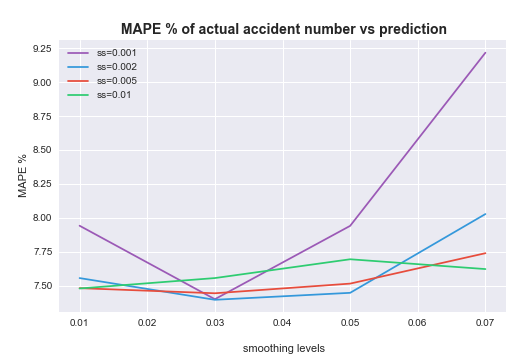

In [11]:
sns.set()
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(smoothing_levels, result_exp_smoothing[0,:], label='ss=0.001', color="#9b59b6")
ax.plot(smoothing_levels, result_exp_smoothing[1,:], label='ss=0.002', color="#3498db")
ax.plot(smoothing_levels, result_exp_smoothing[2,:], label='ss=0.005', color="#e74c3c")
ax.plot(smoothing_levels, result_exp_smoothing[3,:], label='ss=0.01', color="#2ecc71")
ax.set_title('\n MAPE % of actual accident number vs prediction', fontsize=14, fontweight='bold')
ax.set(ylabel='\n MAPE %')
ax.set(xlabel='\n smoothing levels')
ax.legend(['ss=0.001', 'ss=0.002', 'ss=0.005', 'ss=0.01'], loc='upper left')


In [12]:
expo_model = ExponentialSmoothing(trend='add',endog=train)
model_expo_fit = expo_model.fit(smoothing_level=0.03, smoothing_slope=0.002)

In [13]:
y1 = model_expo_fit.predict(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [14]:
train.tail()

Date
2015-04-26    2817
2015-05-03    2716
2015-05-10    2538
2015-05-17    2841
2015-05-24    2716
Freq: W-SUN, dtype: int64

In [15]:
mape1 = np.mean(np.abs((y1.values - test.values) / test.values)) * 100

In [16]:
mape1

7.3948313666729995

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


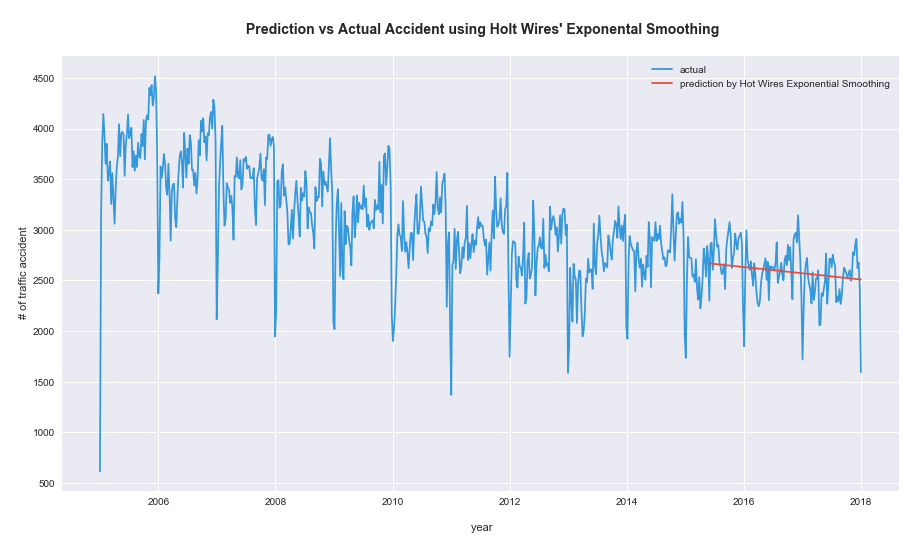

In [17]:

sns.set()
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(new_df.index, new_df.values.flatten(), label='actual', color="#3498db")
ax.plot(x_test, y1.values, label='prediction', color="#e74c3c")
ax.set_title('\n Prediction vs Actual Accident using Holt Wires\' Exponental Smoothing\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\n # of traffic accident')
ax.set(xlabel='\n year')
ax.legend(['actual', 'prediction by Hot Wires Exponential Smoothing'], loc='upper right')


In [18]:
orders = [(3,1,0), (3,1,1), (3,1,2), (3,1,3)]
seasonal_orders = [(3,1,2,1),(3,1,2,2), (3,1,2,3), (3,1,2,4)]
result_sarimax_smoothing = []


In [19]:
for idx, i in enumerate(orders):
    result_sarimax_smoothing.append([])
    for j in seasonal_orders:
        model = SARIMAX(train,order = i,seasonal_order = j,enforce_stationarity = False, enforce_invertibility = False)
        model_fit = model.fit(disp=False)
        y1 = model_fit.get_prediction(start='2015-05-31', end='2017-12-31')
        mape1 = np.mean(np.abs((y1.predicted_mean - test.values) / test.values)) * 100
        result_sarimax_smoothing[idx].append(mape1)

result_sarimax_smoothing = np.array(result_sarimax_smoothing)
print(result_sarimax_smoothing)

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning

[[ 7.37757773  7.89235412  8.36766159  7.37693379]
 [ 7.41735099  7.50034565 10.48164235  7.23427281]
 [ 7.68831557  7.72715482  8.1037799   7.56972998]
 [ 7.49656645  7.69349833  7.9772217   7.42802753]]


In [20]:
result_sarimax_smoothing[0,:]

array([7.37757773, 7.89235412, 8.36766159, 7.37693379])

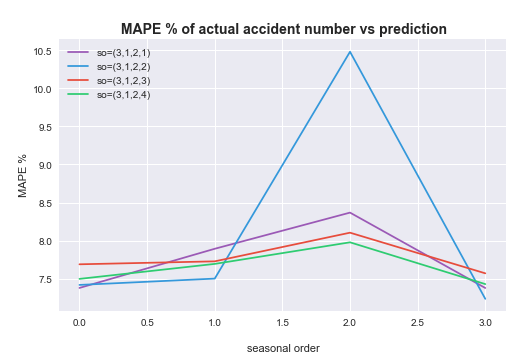

In [21]:
sns.set()
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.array([0,1,2,3]),result_sarimax_smoothing[0,:], label='o=(3,1,0)', color="#9b59b6")
ax.plot(np.array([0,1,2,3]),result_sarimax_smoothing[1,:], label='o=(3,1,1)', color="#3498db")
ax.plot(np.array([0,1,2,3]),result_sarimax_smoothing[2,:], label='o=(3,1,2)', color="#e74c3c")
ax.plot(np.array([0,1,2,3]),result_sarimax_smoothing[3,:], label='o=(3,1,3)', color="#2ecc71")
ax.set_title('\n MAPE % of actual accident number vs prediction', fontsize=14, fontweight='bold')
ax.set(ylabel='\n MAPE %')
ax.set(xlabel='\n seasonal order')
ax.legend(['so=(3,1,2,1)', 'so=(3,1,2,2)', 'so=(3,1,2,3)', 'so=(3,1,2,4)'], loc='upper left')


In [22]:
model2 = SARIMAX(train,order = (3,1,1),seasonal_order = (3,1,2,4),enforce_stationarity = False, enforce_invertibility = False)
model_fit2 = model2.fit(disp=False)

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
yhat = model_fit2.get_prediction(start='2015-05-31', end='2017-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [24]:
mape2 = np.mean(np.abs((yhat.predicted_mean - test.values) / test.values)) * 100

In [25]:
mape2

7.2342728141896755

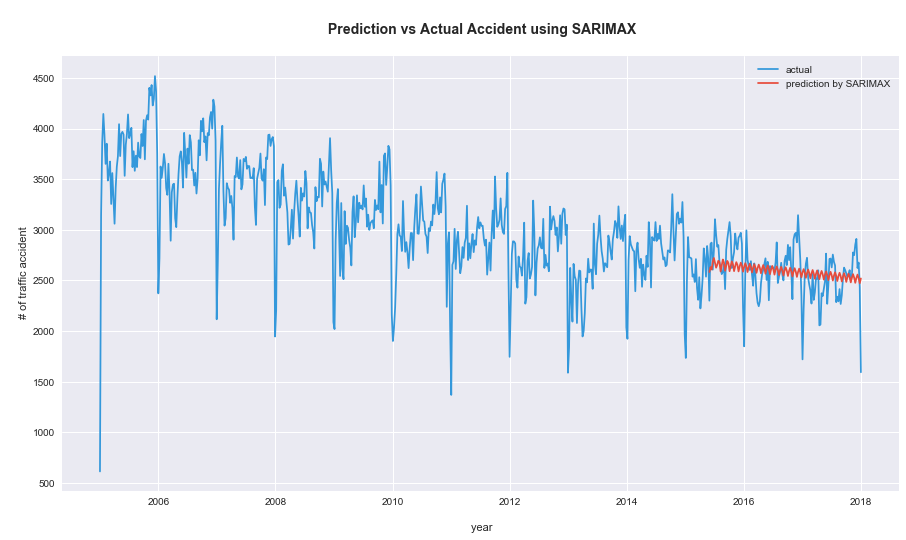

In [26]:
sns.set()
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(new_df.index, new_df.values.flatten(), label='actual', color="#3498db")
ax.plot(x_test, yhat.predicted_mean, label='prediction', color="#e74c3c")
ax.set_title('\n Prediction vs Actual Accident using SARIMAX\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\n # of traffic accident')
ax.set(xlabel='\n year')
ax.legend(['actual', 'prediction by SARIMAX'], loc='upper right')



In [27]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [28]:
model1 = ARIMA(endog=train, order=(1, 1, 1))

In [29]:
model_fit_1 = model1.fit(disp=False)

In [30]:
yhat_1 = model_fit_1.predict(start='2015-05-31', end='2017-12-31', typ='levels')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [31]:
mape3 = np.mean(np.abs((yhat_1 - test.values) / test.values)) * 100

In [32]:
mape3

10.186529701195584

In [33]:
serious = dd[dd['Accident_Severity']=='Serious']
slight = dd[dd['Accident_Severity']=='Slight']
fatal = dd[dd['Accident_Severity']=='Fatal']

serious = serious.set_index('Date').resample('W').size()
slight = slight.set_index('Date').resample('W').size()
fatal = fatal.set_index('Date').resample('W').size()

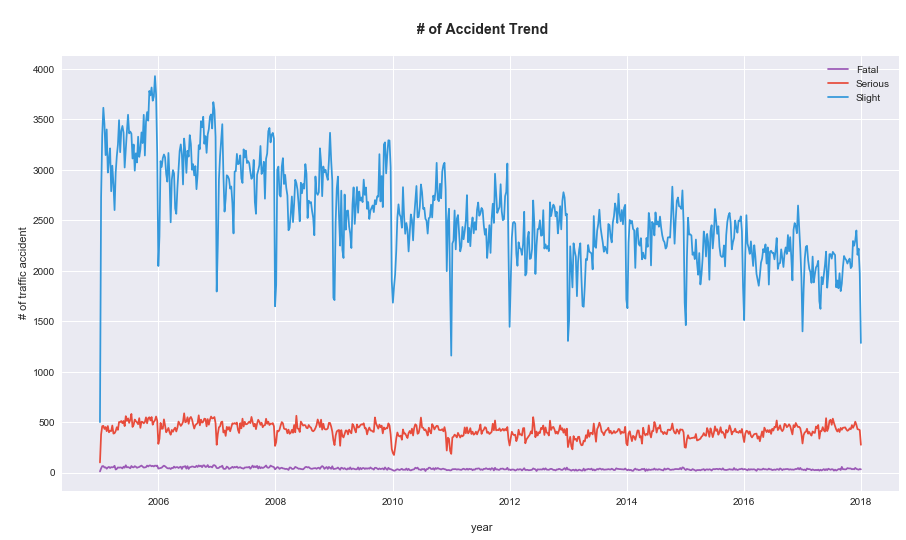

In [34]:

sns.set()
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(fatal, label='Fatal', color="#9b59b6")
ax.plot(serious, label='Serious', color="#e74c3c")
ax.plot(slight, label='Slight', color="#3498db")
ax.set_title('\n # of Accident Trend\n', fontsize=14, fontweight='bold')
ax.set(ylabel='\n # of traffic accident')
ax.set(xlabel='\n year')
ax.legend(['Fatal', 'Serious', 'Slight'], loc='upper right')



In [35]:
serious = dd[dd['Accident_Severity']=='Serious']

In [36]:
df = pd.merge(accident_info, vehicle_info, how = 'inner', on = 'Accident_Index')


In [37]:
serious_more = df[df['Accident_Severity']=='Serious']

In [38]:

serious_more.drop_duplicates(subset ="Accident_Index", 
                     keep = False, inplace = True) 
serious_more.shape

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(121658, 57)

In [39]:
serious_more.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year_y
18,200501BS00022,A,4.0,Unclassified,0.0,Serious,None,2005-01-08,Saturday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Car,No,Front,2005
39,200501BS70029,B,450.0,NaN,0.0,Serious,None,2005-02-15,Tuesday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle over 500cc,No,Front,2005
56,200501BS70066,A,315.0,NaN,0.0,Serious,None,2005-03-01,Tuesday,2.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Overtaking static vehicle - offside,1,Motorcycle 50cc and under,No,Nearside,2005
76,200501BS70096,A,3220.0,NaN,0.0,Serious,None,2005-03-16,Wednesday,1.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Overtaking moving vehicle - offside,1,Motorcycle 125cc and under,No,Front,2005
85,200501BS70125,A,315.0,C,0.0,Serious,None,2005-03-17,Thursday,3.0,...,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,2,Bus or coach (17 or more pass seats),No,Front,2005


In [40]:
vehicle_type = serious_more[['Accident_Index','Vehicle_Type']]

In [41]:
v = vehicle_type.groupby('Vehicle_Type')


In [42]:
vehicle_type.index

Int64Index([     18,      39,      56,      76,      85,      98,     118,
                131,     137,     161,
            ...
            2058164, 2058186, 2058247, 2058250, 2058251, 2058262, 2058323,
            2058341, 2058362, 2058363],
           dtype='int64', length=121658)

In [43]:
v.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(100).reset_index()

,Vehicle_Type,Accident_Index
0,Car,78438
1,Motorcycle over 500cc,11551
2,Bus or coach (17 or more pass seats),5979
3,Van / Goods 3.5 tonnes mgw or under,5856
4,Motorcycle 125cc and under,5301
5,Taxi/Private hire car,3281
6,Goods 7.5 tonnes mgw and over,3229
7,Motorcycle over 125cc and up to 500cc,2723
8,Motorcycle 50cc and under,1707
9,Goods over 3.5t. and under 7.5t,999


In [44]:
vehicle_age = serious_more[['Accident_Index','Age_of_Vehicle']]
v_a = vehicle_age.groupby('Age_of_Vehicle')
v_a.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Age_of_Vehicle,Accident_Index
0,1.0,10230
1,2.0,8849
2,4.0,8348
3,3.0,8340
4,5.0,7943
5,6.0,7696
6,7.0,7416
7,8.0,7184
8,9.0,6688
9,10.0,6390


In [45]:
vehicle_move = serious_more[['Accident_Index','Vehicle_Manoeuvre']]
v_mm = vehicle_move.groupby('Vehicle_Manoeuvre')
v_mm.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Vehicle_Manoeuvre,Accident_Index
0,Going ahead other,64015
1,Turning right,11303
2,Going ahead right-hand bend,9628
3,Going ahead left-hand bend,7950
4,Moving off,4607
5,Slowing or stopping,4275
6,Turning left,4215
7,Parked,3268
8,Overtaking moving vehicle - offside,2702
9,Reversing,2621


In [46]:
vehicle_make = serious_more[['Accident_Index','make']]
v_m = vehicle_make.groupby('make')
v_m.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,make,Accident_Index
0,VAUXHALL,12379
1,FORD,11454
2,HONDA,8138
3,PEUGEOT,6688
4,RENAULT,5802
5,VOLKSWAGEN,5556
6,MERCEDES,4523
7,SUZUKI,4401
8,CITROEN,4165
9,TOYOTA,4131


In [47]:
driver_age = serious_more[['Accident_Index','Age_Band_of_Driver']]
d_a = driver_age.groupby('Age_Band_of_Driver')
d_a.agg(
    {"Accident_Index": len}).sort_values(
    "Accident_Index", ascending=False).head(20).reset_index()

,Age_Band_of_Driver,Accident_Index
0,36 - 45,24513
1,26 - 35,23659
2,46 - 55,20148
3,21 - 25,13880
4,56 - 65,12655
5,16 - 20,11678
6,66 - 75,5637
7,Data missing or out of range,5557
8,Over 75,3820
9,11 - 15,104


In [48]:
fatal   = accident_info.Accident_Severity.value_counts()['Fatal']
serious = accident_info.Accident_Severity.value_counts()['Serious']
slight  = accident_info.Accident_Severity.value_counts()['Slight']

names = ['Fatal Accidents','Serious Accidents', 'Slight Accidents']
size  = [fatal, serious, slight]

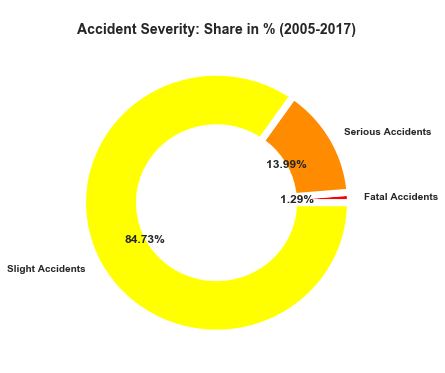

In [41]:
# create a pie chart
plt.pie(x=size, labels=names, colors=['red', 'darkorange', 'yellow'], 
        autopct='%1.2f%%', pctdistance=0.6, textprops=dict(fontweight='bold'),
        wedgeprops={'linewidth':7, 'edgecolor':'white'})

# create circle for the center of the plot to make the pie look like a donut
my_circle = plt.Circle((0,0), 0.6, color='white')

# plot the donut chart
fig = plt.gcf()
fig.set_size_inches(6,6)
fig.gca().add_artist(my_circle)
plt.title('\nAccident Severity: Share in % (2005-2017)', fontsize=14, fontweight='bold')
plt.show()

In [49]:
import ipywidgets as widgets

In [69]:
a = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)
a

A Jupyter Widget

In [70]:
a.value

In [71]:
str_date = a.value.strftime("%Y-%m-%d")
str_date

AttributeError: 'NoneType' object has no attribute 'strftime'

In [68]:
prediction  = model_fit2.get_prediction(start=str_date, end='2020-12-31')

/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:336: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)
/Users/shengtaoli/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:342: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [65]:
prediction.predicted_mean

2015-05-31    2583.515020
2015-06-07    2632.060476
2015-06-14    2608.367372
2015-06-21    2684.637383
2015-06-28    2722.560600
2015-07-05    2674.309827
2015-07-12    2626.211147
2015-07-19    2654.817271
2015-07-26    2695.096907
2015-08-02    2681.916951
2015-08-09    2588.630468
2015-08-16    2648.998910
2015-08-23    2707.224799
2015-08-30    2678.350145
2015-09-06    2595.885101
2015-09-13    2644.609837
2015-09-20    2693.439502
2015-09-27    2670.043311
2015-10-04    2591.380349
2015-10-11    2643.326536
2015-10-18    2688.713488
2015-10-25    2661.443493
2015-11-01    2592.222766
2015-11-08    2641.181933
2015-11-15    2681.151703
2015-11-22    2653.396523
2015-11-29    2589.634970
2015-12-06    2638.699789
2015-12-13    2675.971378
2015-12-20    2646.294897
                 ...     
2017-06-11    2503.896907
2017-06-18    2551.672700
2017-06-25    2585.383669
2017-07-02    2550.971366
2017-07-09    2499.390399
2017-07-16    2547.165020
2017-07-23    2580.877124
2017-07-30  